In [7]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tnrange, tqdm
%matplotlib inline

In [8]:
#constants
c=2.99792458*1e10 #speed of light in cm/s
c2 = 1.4387769 #second radiation constant, hc/k, in cm*K
T_ref = 276 #HITRAN reference temp in K

In [9]:
earth_infile = '/Users/saravannah/AstroSpec/Exo_Transmit_spectra/earth.txt'
earth_wave, earth_flux = np.loadtxt(earth_infile, unpack=True, skiprows=2)
earth_wave = earth_wave * 1e6

In [18]:
test_infile =  '/Users/saravannah/Exo_Transmit/Spectra/test_planet.dat'
test_wave, test_flux = np.loadtxt(test_infile, unpack=True, skiprows=2)
test_wave = test_wave * 1e6

In [11]:
#this is a big file - will take a minute to load it in
hitran_infile = '/Users/saravannah/Desktop/H2O_big/61af93db.txt'#'/Users/saravannah/AstroSpec/Kempton_line_lists/onlyH2O_CO_CO2_CH4/619d10f5.out.txt' #'/Users/saravannah/AstroSpec/Kempton_line_lists/618ec803.out.txt'
nu_spec, S_spec, A, E_lower, iso_ID, molec_ID, _, _, _= np.loadtxt(hitran_infile, unpack=True, skiprows=1)

In [12]:
#later you will have to change this to take molec_ID and iso_ID
#and look for diff molecules in diff file locations

#get partition function evaluated at T
def get_partition_function(T, ID):
    
    q_fileName = 'q'+str(int(ID))+'.txt'
    temp, Q = np.loadtxt('/Users/saravannah/Desktop/H2O/partitions/'+q_fileName, unpack=True)
    idx = np.where(temp == T)
    
    return float(Q[idx])

From the HITRAN documentation, we have the spectral line intensity, $S_{ij}$, for a transition from state $i$ to state $j$ goes as  
$$S_{ij} = I_a \frac{A_{ij}}{8\pi c \nu_{ij}^2} \frac{g' e^{-c_2 E''/T} (1-e^{-c_2 \nu_{ij}/T})}{Q(T)}$$
where $A_{ij}$ is the Einstein-A coefficient for spontaneous emission, $g'$ is the upper state degeneracy (or "statistcal weight"), and $E''$ is the lower energy state. HITRAN gives $S_{ij}$ at a reference temperature, $T_{ref}=296K$. We can then convert from the reference intensity to the intensity at a particular atmospheric temperature by taking the ratio
$$\frac{S_{ij}}{S_{ij,ref}} = \frac{Q(T_{ref})}{Q(T)} e^{-c_2 E''/T + -c_2 E''/T_{ref}} \frac{(1-e^{-c_2 \nu_{ij}/T})}{(1-e^{-c_2 \nu_{ij}/T_{ref}})}.$$

In [13]:
#get line intensity at particular temperature

#ID is HITRAN ID for isotopologue
#later will need to add ID for molecule, too
def convert_intensity(S_ref, T, lower_energy, ID):
    Q = get_partition_function(T, ID)
    Q_ref = get_partition_function(T_ref, ID)
    S = S_ref * Q_ref/Q * np.exp(-c2*lower_energy/T)/np.exp(-c2*lower_energy/T_ref) *(1-np.exp(-c2*lower_energy/T))/(1-np.exp(-c2*lower_energy/T_ref))
    
    return S

In [14]:
#This is not very pythonic, but it's slow so wanted progress bar
S_converted = []
for t in tnrange(len(nu_spec)):
    S_converted.append(convert_intensity(S_spec[t], 1000, E_lower[t], iso_ID[t]))

  0%|          | 0/30137 [00:00<?, ?it/s]

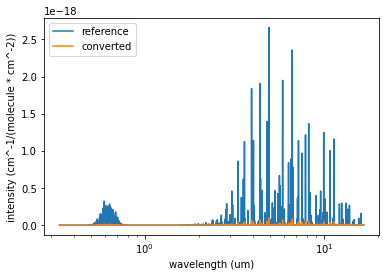

In [15]:

plt.plot(1/nu_spec*1e3, S_spec, label='reference')
plt.plot(1/nu_spec*1e3, S_converted, label='converted')
#plt.plot(1/nu_spec*1e3, np.abs(S_spec-S_converted), label='reference')
plt.xlabel('wavelength (um)')
plt.ylabel('intensity (cm^-1/(molecule * cm^-2))')
plt.xscale('log')
plt.legend()
#plt.xlim([0,15])

In [21]:
print(len(S_converted))

30137


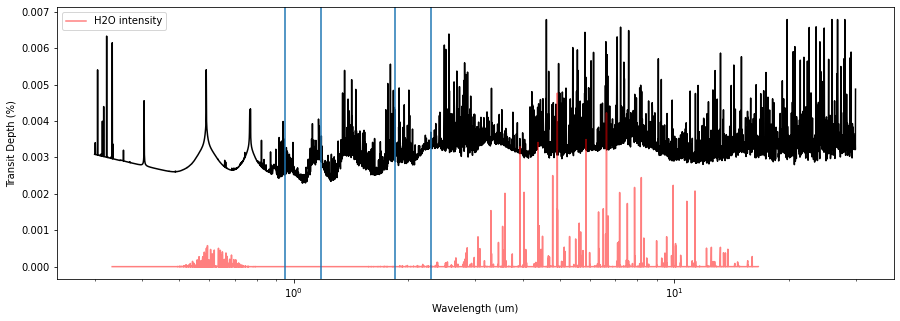

In [21]:
#plt.plot(earth_wave, earth_flux, color='black')
plt.plot(test_wave, test_flux, color='black')
plt.plot(1/nu_spec*1e3, np.array(S_converted)*5e16, label='H2O intensity', alpha=0.5, color='red')
plt.xscale('log')
plt.xlabel('Wavelength (um)')
plt.ylabel('Transit Depth (%)')

plt.axvline(0.95)
plt.axvline(1.18)
plt.axvline(1.85)
plt.axvline(2.3)

plt.gcf().set_size_inches(15, 5)
plt.legend()

plt.savefig('waterLines.png')

In [32]:
#This is not very pythonic, but it's slow so wanted progress bar
S_earth = []
for t in tnrange(len(nu_spec)):
    S_earth.append(convert_intensity(S_spec[t], 288, E_lower[t], iso_ID[t]))

  0%|          | 0/30137 [00:00<?, ?it/s]

In [117]:
#print(max(S_converted), min(S_converted))
S_threshold = 0.1* max(S_converted)#1e-19
hitran_mini = {'nu':[], 'molec_ID':[], 'iso_ID':[]}
for i in range(len(nu_spec)):
    if S_converted[i]>S_threshold:
        hitran_mini['nu'].append(nu_spec[i])
        hitran_mini['molec_ID'].append(molec_ID[i])
        hitran_mini['iso_ID'].append(iso_ID[i])
        
print(len(hitran_mini['nu']))


54


In [118]:
#convert from wavenumber (in inverse cm) to wavelength (in um)
def nu_to_lambda(nu):
    return 1e3*np.reciprocal(nu)

In [119]:
def get_name(ID):
    names = {'1':'H2O', '2':'CO2', '3':'O3','4':'N2O','5':'CO','6':'CH4','7':'O2','8':'NO','9':'SO2',
           '10':'NO2','11':'NH3','12':'HNO3','13':'OH','14':'HF','15':'HCl','16':'HBr','17':'HI','18':'ClO',
           '19':'OCS','20':'H2CO','21':'HOCl','22':'N2','23':'HCN','24':'CH3Cl','25':'H2O2','26':'C2H2',
           '27':'C2H6','28':'PH3', '29':'COF3', '30':'SF6','31':'H2S','32':'HCOOH','33':'HO2','34':'O',
           '35':'ClONO2','36':'NO+','37':'HOBr','38':'C2H4','39':'CH3OH','40':'CH3Br','41':'CH3CN','42':'CF4',
           '43':'C4H2','44':'HC3N','45':'H2','46':'CS','47':'SO3','48':'C2N2','49':'COCl2','50':'SO','51':'CH3F',
           '52':'GeH4','53':'CS2','54':'CH3I','55':'NF3'}
    molec_name = names[str(int(ID))]
    return molec_name

In [120]:
#check if there's an absorption line very close by
def is_line_nearby(wavelength, waves):
    threshold = 1e-1 #distance in um to next absorption line
    idx = waves.index(wavelength)
    
    #check if the next larger line is close enough
    if idx < len(waves)-1 and abs(wavelength - waves[waves.index(wavelength)+1]) < threshold:
        return True
    else:
        return False

In [121]:
##NOTE: use this only for molecules of the same type!!!! 

def get_bands(waves):
    
    bands = [] #this is a list of the **centers** of each band
    band_widths = []
    current_band = [] #this is a list of all the individual lines inside the current band
    
    for wavelength in waves:
        if wavelength not in current_band and is_line_nearby(wavelength, waves):
            current_band.append(wavelength)
        #if the last wavelength was in the current band, add the center of that band to bands and reset
        elif waves[waves.index(wavelength) -1] in current_band:
            band_center = np.mean(current_band)
            band_width = [current_band[0], current_band[len(current_band)-1]]
            bands.append(band_center)
            band_widths.append(band_width)
            current_band = [] #reset current band
    return bands, band_widths

In [124]:
#get all waves of the same ID/type
def get_type(data, molec_ID, iso_ID):
    waves_arr = []
    for i in range(len(data['molec_ID'])):
        if get_name(data['molec_ID'][i]) == molec_ID and data['iso_ID'][i] == iso_ID:
            waves_arr.append(nu_to_lambda(data['nu'][i]))

    return waves_arr
        

In [125]:
H2O_1 = get_type(hitran_mini, 'H2O', 1)
H2O_bands_1, H2O_band_widths_1 = get_bands(H2O_1)

H2O_2 = get_type(hitran_mini, 'H2O', 2)
H2O_bands_2, H2O_band_widths_2 = get_bands(H2O_2)

#CH4 = get_type(hitran_mini, 'CH4')
#CH4_bands, CH4_band_widths = get_bands(CH4)

In [127]:
print(len(H2O_bands_1), len(H2O_1))
print(len(H2O_bands_2), len(H2O_2))

0 0
0 0


In [108]:
test1, test2 = H2O_band_widths[2]

print(test1)

IndexError: list index out of range

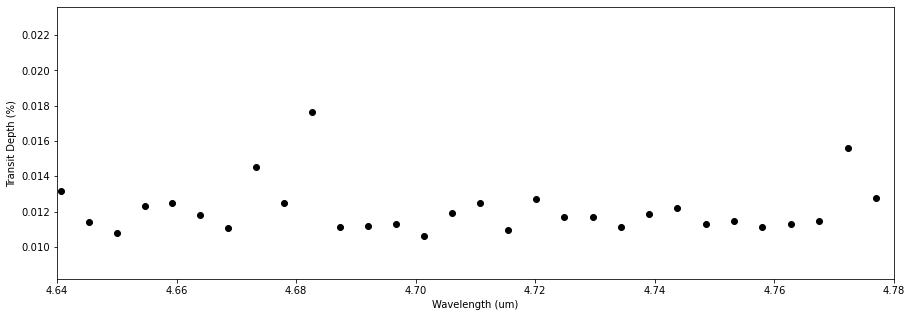

In [109]:
plt.scatter(earth_wave, earth_flux, color='black')
plt.xlabel('Wavelength (um)')
plt.ylabel('Transit Depth (%)')
plt.xlim([4.64,4.78])
plt.gcf().set_size_inches(15, 5)

In [110]:
#names_to_plot = ['H2O', 'CO', 'CO2', 'CH4']
names_to_plot = ['CH4']

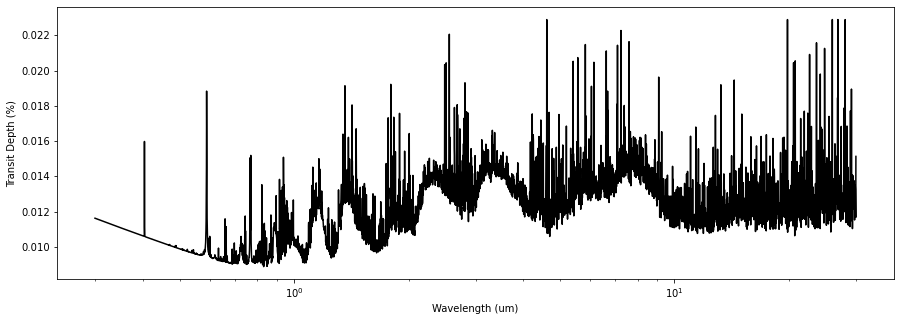

In [111]:
plt.plot(earth_wave, earth_flux, color='black')
for i in range(len(H2O_bands)):
    beg, end = H2O_band_widths[i]
    plt.axvline(H2O_bands[i],color='red', linestyle='dashed')
    plt.axvspan(beg, end, alpha=0.5, color = 'pink')

plt.xscale('log')
plt.xlabel('Wavelength (um)')
plt.ylabel('Transit Depth (%)')
#plt.xlim([0,8])
plt.gcf().set_size_inches(15, 5)

NameError: name 'CH4_bands' is not defined

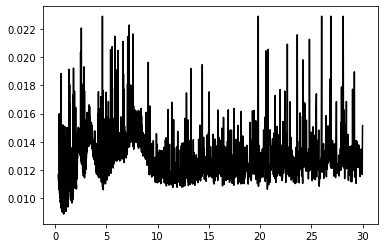

In [112]:
plt.plot(earth_wave, earth_flux, color='black')
for i in range(len(CH4_bands)):
    beg, end = CH4_band_widths[i]
    plt.axvline(CH4_bands[i],color='red', linestyle='dashed')
    plt.axvspan(beg, end, alpha=0.5, color = 'pink')

#plt.xscale('log')
plt.xlabel('Wavelength (um)')
plt.ylabel('Transit Depth (%)')
plt.xlim([0,8])
plt.gcf().set_size_inches(15, 5)


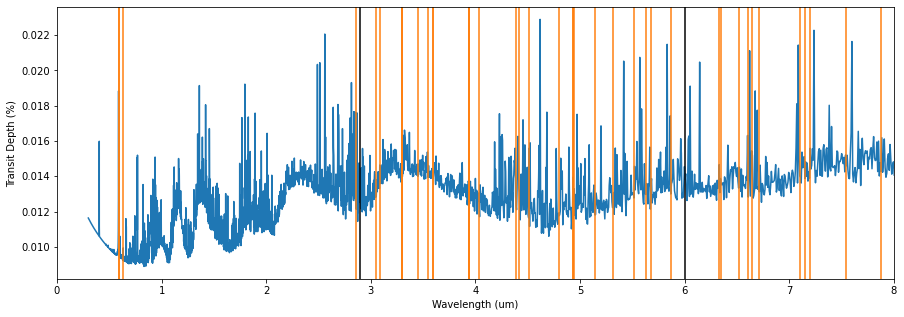

In [133]:
plt.plot(earth_wave, earth_flux)
##this also takes a minute - drawing vertical lines is expensive in Python
#for i,mywave in enumerate(hitran_mini['nu']):
#    plt.axvline(nu_to_lambda(hitran_mini['nu'][i]),color='C1')
#    plt.text(nu_to_lambda(hitran_mini['nu'][i]),0.02,get_name(hitran_mini['ID'][i]))

for i, mywave in enumerate(hitran_mini['nu']):
    if hitran_mini['iso_ID'][i] == 1:
        plt.axvline(nu_to_lambda(hitran_mini['nu'][i]),color='C1')
    elif hitran_mini['iso_ID'][i] == 1:
        plt.axvline(nu_to_lambda(hitran_mini['nu'][i]),color='C2')
    
        


#plt.xscale('log')
plt.axvline(6, color='black') 
plt.axvline(2.9, color='black') #X band
plt.xlabel('Wavelength (um)')
plt.ylabel('Transit Depth (%)')
plt.xlim([0,8])
plt.gcf().set_size_inches(15, 5)